In [1]:
%load_ext autoreload

import pandas as pd, numpy as np, matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.preprocessing import OneHotEncoder

import time
from tqdm import tqdm
from datetime import datetime

import torch
from torch import nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn.init as init

from feature_engineering import replace_abnormal, add_features
from datasets import ObsDataset, TestDataset, get_dataloaders, random_split, random_k_fold
from models import biLSTMClassifier, biGRUClassifier
from utils import get_device, init_rnn, EarlyStopper

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None

/home/hugocth/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset

raw_train_data = pd.read_csv("data/X_train_N1UvY30.csv")
raw_target_data = pd.read_csv("data/y_train_or6m3Ta.csv")
raw_test_data = pd.read_csv("data/X_test_m4HAPAP.csv")

In [3]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch, shortcut=0):
    size = len(dataloader.dataset)
    model.train()
    num_batches = len(dataloader)

    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        out = model(X)
        
        loss = loss_fn(out, y)
        train_loss += loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if out.std() < 0.000001:
            print("WARNING: std() is zero, stopping")
            break

        if shortcut > 0 and batch == shortcut:
            return train_loss.detach().cpu().numpy() / shortcut
    return train_loss.detach().cpu().numpy() / num_batches


def test_loop(dataloader, model, loss_fn, scheduler, epoch, return_acc=True):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            out = model(X)
            test_loss += loss_fn(out, y).detach().cpu().numpy()
            acc += (torch.sum(out.argmax(axis=1) == y)/len(y)).item()

        scheduler.step(test_loss)
    
    if return_acc:
        return test_loss / num_batches, acc / num_batches
    else:
        return test_loss / num_batches

def predict(X, model):
    model.eval()
    with torch.no_grad():
        X = X.to(device)
        output = model(X)
        pred = output.argmax(axis=1)
    return pred.detach().cpu().numpy().flatten()

def experiment(model, train_dataloader, val_dataloader, epochs, lr):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.00001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=8, factor=0.5, verbose=True)
    early_stopper = EarlyStopper(patience=15, min_delta=0.0001)

    history = pd.DataFrame([], columns=["epoch","train_loss","val_loss", "acc","lr"])

    for epoch in range(epochs):
        train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, epoch, shortcut=0)
        val_loss, acc = test_loop(val_dataloader, model, loss_fn, scheduler, epoch, return_acc=True)

        history.loc[len(history),:] = [epoch+1, train_loss, val_loss, acc, optimizer.param_groups[0]['lr']]
        
        print(f"Epoch {epoch}/{epochs} | Train loss {train_loss:4f} | Val loss {val_loss:4f} | Acc {acc:4f} | lr {lr}")

        if early_stopper.early_stop(val_loss, acc, model):
            model = early_stopper.get_best_model()
            break
    
    # Plot history
    fig, ax = plt.subplots((1,2))
    ax = ax.flatten()

    history[['train_loss', 'val_loss']].plot(title='Losses', ax=ax[0])
    history[['acc']].plot(title='Acc', ax=ax[1])
    plt.show()

    return model

class CV_pytorch:

    def __init__(self, cv, epochs, verbose=False) -> None:
        self.lengths = [1/cv for i in range(cv)]
        self.epochs = epochs
        self.best_val_losses = []
        self.best_accs = []
        self.best_models = []
        self.histories = []
        self.verbose = verbose

    def __call__(self, RNN_params, MLP_params, dataset, lr, rnn_type="lstm", embeddings=False, only_one=False):

        self.n_folds = len(self.lengths)
        
        for i, (train_dataset, val_dataset) in enumerate(random_k_fold(dataset, self.lengths)):
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
            val_dataloader = DataLoader(val_dataset, batch_size=min(batch_size*4, len(val_dataset)), drop_last=True)
            if rnn_type == "lstm":
                model = biLSTMClassifier(RNN_params, MLP_params, embeddings)
            elif rnn_type == "gru":
                model = biGRUClassifier(RNN_params, MLP_params, embeddings)
            model = model.to(device)
            if i == 0:
                n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
                print("Number of learnable parameters:", n_parameters)

            if only_one:
                print("Experiment with only one fold")
                model = experiment(model, train_dataloader, val_dataloader, self.epochs, lr)
                return model
            
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.00001)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=8, factor=0.5, verbose=True)
            early_stopper = EarlyStopper(patience=15, min_delta=0.0001, verbose=self.verbose)

            history = pd.DataFrame([], columns=["epoch","train_loss","val_loss", "acc","lr"])

            for epoch in tqdm(range(self.epochs), desc=f'Fold {i}'):
                train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, epoch, shortcut=0)
                val_loss, acc = test_loop(val_dataloader, model, loss_fn, scheduler, epoch, return_acc=True)

                history.loc[len(history),:] = [epoch+1, train_loss, val_loss, acc, optimizer.param_groups[0]['lr']]

                if early_stopper.early_stop(val_loss, acc, model):
                    model = early_stopper.get_best_model()
                    break
            
            print(f"Best val loss: {early_stopper.min_validation_loss} | Best acc: {early_stopper.best_acc}")
            
            self.best_models.append(model)
            self.best_val_losses.append(early_stopper.min_validation_loss)
            self.best_accs.append(early_stopper.best_acc)
            self.histories.append(history)

        return self.best_models[np.argmin(self.best_val_losses)]
    
    def plot_history(self):
        metrics = ["train_loss","val_loss", "acc", "lr"]
        stats = pd.DataFrame(np.zeros((self.epochs, len(metrics))), columns=metrics)

        fig, ax = plt.subplots(1,3, figsize=(15,5))
        ax = ax.flatten()

        for history in self.histories:
            stats[metrics] += history[metrics]
        stats = stats/len(self.lengths)
        stats[['train_loss', 'val_loss']].plot(title='Avg losses', ax=ax[0])
        stats[['acc']].plot(title='Avg val acc', ax=ax[1])
        stats[["lr"]].plot(title="Avg lr", ax=ax[2])
        plt.show()

In [4]:
# Dataset

device = get_device()
print(f"Using {device}.")

batch_size = 1024
embeddings = True # True to encode categorical variables into 8-vector embeddings, False to use one-hot encoding

train_data = replace_abnormal(raw_train_data)
target_data = raw_target_data
train_data, features = add_features(train_data, embeddings=embeddings)
x_cols = features[:]
full_dataset= ObsDataset(train_data, target_data, x_cols)

Replaced 41 abnormal observations.
Feature engineering completed: 14 features.


Using cuda:0.
Number of learnable parameters: 708808


Fold 0:   1%|          | 1/100 [00:14<24:10, 14.66s/it]

New best loss: 2.201544
Acc: 0.26053292410714285


Fold 0:   2%|▏         | 2/100 [00:29<24:21, 14.91s/it]

New best loss: 1.816971
Acc: 0.38985770089285715


Fold 0:   3%|▎         | 3/100 [00:45<24:22, 15.08s/it]

New best loss: 1.562160
Acc: 0.46505301339285715


Fold 0:   4%|▍         | 4/100 [01:00<24:13, 15.14s/it]

New best loss: 1.397312
Acc: 0.51904296875


Fold 0:   5%|▌         | 5/100 [01:14<23:17, 14.71s/it]

New best loss: 1.230888
Acc: 0.5784388950892857


Fold 0:   6%|▌         | 6/100 [01:27<22:29, 14.36s/it]

New best loss: 1.147022
Acc: 0.609619140625


Fold 0:   7%|▋         | 7/100 [01:41<21:46, 14.05s/it]

New best loss: 1.076122
Acc: 0.6309291294642857


Fold 0:   8%|▊         | 8/100 [01:55<21:25, 13.98s/it]

New best loss: 1.032195
Acc: 0.6492047991071429


Fold 0:   9%|▉         | 9/100 [02:09<21:20, 14.07s/it]

New best loss: 1.009158
Acc: 0.6567034040178571


Fold 0:  10%|█         | 10/100 [02:22<20:50, 13.89s/it]

New best loss: 0.953746
Acc: 0.6751185825892857


Fold 0:  11%|█         | 11/100 [02:36<20:32, 13.85s/it]

New best loss: 0.944241
Acc: 0.6753976004464286


Fold 0:  12%|█▏        | 12/100 [02:50<20:13, 13.79s/it]

New best loss: 0.907965
Acc: 0.6863141741071429


Fold 0:  14%|█▍        | 14/100 [03:17<19:30, 13.61s/it]

New best loss: 0.897835
Acc: 0.6947544642857143


Fold 0:  15%|█▌        | 15/100 [03:30<19:10, 13.53s/it]

New best loss: 0.892140
Acc: 0.6930803571428571


Fold 0:  16%|█▌        | 16/100 [03:43<18:42, 13.37s/it]

New best loss: 0.865828
Acc: 0.7020089285714286


Fold 0:  17%|█▋        | 17/100 [03:56<18:25, 13.32s/it]

New best loss: 0.862558
Acc: 0.7030203683035714


Fold 0:  19%|█▉        | 19/100 [04:23<18:07, 13.42s/it]

New best loss: 0.818047
Acc: 0.719970703125


Fold 0:  20%|██        | 20/100 [04:37<17:44, 13.31s/it]

New best loss: 0.813164
Acc: 0.7198311941964286


Fold 0:  21%|██        | 21/100 [04:50<17:42, 13.45s/it]

New best loss: 0.811162
Acc: 0.719482421875


Fold 0:  23%|██▎       | 23/100 [05:18<17:33, 13.68s/it]

New best loss: 0.802109
Acc: 0.7252022879464286


Fold 0:  25%|██▌       | 25/100 [05:45<16:47, 13.43s/it]

New best loss: 0.791297
Acc: 0.7299107142857143


Fold 0:  26%|██▌       | 26/100 [05:58<16:32, 13.41s/it]

New best loss: 0.789130
Acc: 0.7306082589285714


Fold 0:  27%|██▋       | 27/100 [06:12<16:20, 13.43s/it]

New best loss: 0.779631
Acc: 0.7325962611607143


Fold 0:  28%|██▊       | 28/100 [06:24<15:56, 13.29s/it]

New best loss: 0.778681
Acc: 0.7340611049107143


Fold 0:  30%|███       | 30/100 [06:50<15:06, 12.96s/it]

New best loss: 0.761582
Acc: 0.7410016741071429


Fold 0:  32%|███▏      | 32/100 [07:16<14:48, 13.07s/it]

New best loss: 0.752516
Acc: 0.7438267299107143


Fold 0:  34%|███▍      | 34/100 [07:44<14:45, 13.41s/it]

New best loss: 0.744180
Acc: 0.7491978236607143


Fold 0:  37%|███▋      | 37/100 [08:24<14:12, 13.53s/it]

New best loss: 0.725393
Acc: 0.7544294084821429


Fold 0:  46%|████▌     | 46/100 [10:25<11:56, 13.26s/it]

New best loss: 0.722307
Acc: 0.7556501116071429


Fold 0:  55%|█████▌    | 55/100 [12:26<10:02, 13.40s/it]

Epoch    55: reducing learning rate of group 0 to 5.0000e-03.


Fold 0:  56%|█████▌    | 56/100 [12:39<09:47, 13.34s/it]

New best loss: 0.663603
Acc: 0.7822265625


Fold 0:  65%|██████▌   | 65/100 [14:39<07:41, 13.17s/it]

Epoch    65: reducing learning rate of group 0 to 2.5000e-03.


Fold 0:  70%|███████   | 70/100 [15:58<06:50, 13.70s/it]


Best val loss: 0.6636028630392892 | Best acc: 0.7822265625


Fold 1:   1%|          | 1/100 [00:12<21:00, 12.73s/it]

New best loss: 2.249483
Acc: 0.23744419642857142


Fold 1:   2%|▏         | 2/100 [00:26<21:35, 13.22s/it]

New best loss: 1.906136
Acc: 0.36118861607142855


Fold 1:   3%|▎         | 3/100 [00:39<21:14, 13.14s/it]

New best loss: 1.657005
Acc: 0.44192940848214285


Fold 1:   4%|▍         | 4/100 [00:52<21:00, 13.13s/it]

New best loss: 1.356278
Acc: 0.5348423549107143


Fold 1:   5%|▌         | 5/100 [01:05<20:39, 13.04s/it]

New best loss: 1.245719
Acc: 0.5718122209821429


Fold 1:   6%|▌         | 6/100 [01:19<20:49, 13.29s/it]

New best loss: 1.197188
Acc: 0.5868094308035714


Fold 1:   7%|▋         | 7/100 [01:32<20:35, 13.29s/it]

New best loss: 1.086179
Acc: 0.62939453125


Fold 1:   8%|▊         | 8/100 [01:45<20:10, 13.15s/it]

New best loss: 1.039815
Acc: 0.6416364397321429


Fold 1:   9%|▉         | 9/100 [01:59<20:30, 13.52s/it]

New best loss: 0.995082
Acc: 0.6600167410714286


Fold 1:  12%|█▏        | 12/100 [02:38<19:18, 13.16s/it]

New best loss: 0.939795
Acc: 0.6785016741071429


Fold 1:  14%|█▍        | 14/100 [03:05<19:16, 13.45s/it]

New best loss: 0.909783
Acc: 0.6888950892857143


Fold 1:  15%|█▌        | 15/100 [03:20<19:21, 13.67s/it]

New best loss: 0.877672
Acc: 0.7000906808035714


Fold 1:  16%|█▌        | 16/100 [03:33<19:03, 13.61s/it]

New best loss: 0.867431
Acc: 0.7004743303571429


Fold 1:  17%|█▋        | 17/100 [03:46<18:30, 13.38s/it]

New best loss: 0.840226
Acc: 0.7120186941964286


Fold 1:  18%|█▊        | 18/100 [03:59<18:00, 13.17s/it]

New best loss: 0.835691
Acc: 0.7144252232142857


Fold 1:  20%|██        | 20/100 [04:27<18:14, 13.68s/it]

New best loss: 0.818163
Acc: 0.7184709821428571


Fold 1:  21%|██        | 21/100 [04:40<17:52, 13.57s/it]

New best loss: 0.807261
Acc: 0.7232491629464286


Fold 1:  22%|██▏       | 22/100 [04:53<17:32, 13.50s/it]

New best loss: 0.804968
Acc: 0.7244001116071429


Fold 1:  24%|██▍       | 24/100 [05:21<17:08, 13.53s/it]

New best loss: 0.801543
Acc: 0.7251674107142857


Fold 1:  25%|██▌       | 25/100 [05:34<16:53, 13.52s/it]

New best loss: 0.788552
Acc: 0.7282366071428571


Fold 1:  26%|██▌       | 26/100 [05:47<16:33, 13.43s/it]

New best loss: 0.785493
Acc: 0.7306780133928571


Fold 1:  27%|██▋       | 27/100 [06:01<16:19, 13.42s/it]

New best loss: 0.781476
Acc: 0.7324567522321429


Fold 1:  28%|██▊       | 28/100 [06:14<16:12, 13.51s/it]

New best loss: 0.764311
Acc: 0.7389439174107143


Fold 1:  31%|███       | 31/100 [06:55<15:24, 13.40s/it]

New best loss: 0.764206
Acc: 0.7373046875


Fold 1:  32%|███▏      | 32/100 [07:08<14:58, 13.21s/it]

New best loss: 0.761789
Acc: 0.7416294642857143


Fold 1:  33%|███▎      | 33/100 [07:20<14:37, 13.10s/it]

New best loss: 0.753756
Acc: 0.7438267299107143


Fold 1:  34%|███▍      | 34/100 [07:34<14:40, 13.34s/it]

New best loss: 0.751165
Acc: 0.745361328125


Fold 1:  35%|███▌      | 35/100 [07:47<14:20, 13.24s/it]

New best loss: 0.730059
Acc: 0.7549176897321429


Fold 1:  41%|████      | 41/100 [09:06<12:58, 13.20s/it]

New best loss: 0.727487
Acc: 0.7537318638392857


Fold 1:  47%|████▋     | 47/100 [10:24<11:37, 13.16s/it]

New best loss: 0.709255
Acc: 0.7637067522321429


Fold 1:  56%|█████▌    | 56/100 [12:22<09:35, 13.07s/it]

Epoch    56: reducing learning rate of group 0 to 5.0000e-03.


Fold 1:  58%|█████▊    | 58/100 [12:47<09:02, 12.92s/it]

New best loss: 0.705038
Acc: 0.7761928013392857


Fold 1:  67%|██████▋   | 67/100 [14:43<07:02, 12.80s/it]

Epoch    67: reducing learning rate of group 0 to 2.5000e-03.


Fold 1:  72%|███████▏  | 72/100 [16:02<06:14, 13.37s/it]


Best val loss: 0.705037806715284 | Best acc: 0.7761928013392857


Fold 2:   1%|          | 1/100 [00:13<21:52, 13.25s/it]

New best loss: 2.136860
Acc: 0.28023856026785715


Fold 2:   2%|▏         | 2/100 [00:26<22:02, 13.49s/it]

New best loss: 1.698986
Acc: 0.4146205357142857


Fold 2:   3%|▎         | 3/100 [00:39<21:30, 13.30s/it]

New best loss: 1.471304
Acc: 0.49874441964285715


Fold 2:   4%|▍         | 4/100 [00:52<20:49, 13.02s/it]

New best loss: 1.326705
Acc: 0.5414341517857143


Fold 2:   5%|▌         | 5/100 [01:05<20:28, 12.93s/it]

New best loss: 1.185798
Acc: 0.5923897879464286


Fold 2:   6%|▌         | 6/100 [01:18<20:19, 12.97s/it]

New best loss: 1.130344
Acc: 0.6150251116071429


Fold 2:   7%|▋         | 7/100 [01:31<20:17, 13.09s/it]

New best loss: 1.085849
Acc: 0.6320103236607143


Fold 2:   8%|▊         | 8/100 [01:45<20:27, 13.34s/it]

New best loss: 1.042143
Acc: 0.6409040178571429


Fold 2:   9%|▉         | 9/100 [01:59<20:27, 13.49s/it]

New best loss: 0.977649
Acc: 0.6640973772321429


Fold 2:  10%|█         | 10/100 [02:12<19:54, 13.28s/it]

New best loss: 0.972487
Acc: 0.668212890625


Fold 2:  11%|█         | 11/100 [02:24<19:22, 13.06s/it]

New best loss: 0.928556
Acc: 0.6817801339285714


Fold 2:  13%|█▎        | 13/100 [02:52<19:29, 13.44s/it]

New best loss: 0.898729
Acc: 0.6856515066964286


Fold 2:  15%|█▌        | 15/100 [03:20<19:32, 13.80s/it]

New best loss: 0.870127
Acc: 0.7012067522321429


Fold 2:  17%|█▋        | 17/100 [03:48<19:11, 13.88s/it]

New best loss: 0.839179
Acc: 0.7084263392857143


Fold 2:  18%|█▊        | 18/100 [04:01<18:34, 13.59s/it]

New best loss: 0.834793
Acc: 0.7106236049107143


Fold 2:  19%|█▉        | 19/100 [04:14<18:05, 13.41s/it]

New best loss: 0.814516
Acc: 0.7186104910714286


Fold 2:  21%|██        | 21/100 [04:40<17:29, 13.28s/it]

New best loss: 0.813348
Acc: 0.7191336495535714


Fold 2:  23%|██▎       | 23/100 [05:06<16:49, 13.11s/it]

New best loss: 0.810209
Acc: 0.7195870535714286


Fold 2:  25%|██▌       | 25/100 [05:33<16:39, 13.32s/it]

New best loss: 0.804264
Acc: 0.7234584263392857


Fold 2:  26%|██▌       | 26/100 [05:46<16:24, 13.30s/it]

New best loss: 0.788228
Acc: 0.7283412388392857


Fold 2:  28%|██▊       | 28/100 [06:13<16:07, 13.44s/it]

New best loss: 0.780113
Acc: 0.7330845424107143


Fold 2:  29%|██▉       | 29/100 [06:27<16:03, 13.57s/it]

New best loss: 0.766202
Acc: 0.7367466517857143


Fold 2:  31%|███       | 31/100 [06:55<15:42, 13.66s/it]

New best loss: 0.763488
Acc: 0.7376534598214286


Fold 2:  32%|███▏      | 32/100 [07:08<15:15, 13.47s/it]

New best loss: 0.744715
Acc: 0.7433035714285714


Fold 2:  34%|███▍      | 34/100 [07:34<14:31, 13.20s/it]

New best loss: 0.744631
Acc: 0.7461635044642857


Fold 2:  37%|███▋      | 37/100 [08:12<13:35, 12.94s/it]

New best loss: 0.717954
Acc: 0.7547433035714286


Fold 2:  42%|████▏     | 42/100 [09:19<12:45, 13.20s/it]

New best loss: 0.706290
Acc: 0.7599748883928571


Fold 2:  51%|█████     | 51/100 [11:20<11:01, 13.50s/it]

Epoch    51: reducing learning rate of group 0 to 5.0000e-03.


Fold 2:  52%|█████▏    | 52/100 [11:35<11:14, 14.04s/it]

New best loss: 0.661667
Acc: 0.7793317522321429


Fold 2:  61%|██████    | 61/100 [13:35<08:49, 13.57s/it]

Epoch    61: reducing learning rate of group 0 to 2.5000e-03.


Fold 2:  66%|██████▌   | 66/100 [14:57<07:42, 13.60s/it]


Best val loss: 0.6616666913032532 | Best acc: 0.7793317522321429


Fold 3:   1%|          | 1/100 [00:13<21:51, 13.25s/it]

New best loss: 2.160206
Acc: 0.2901088169642857


Fold 3:   2%|▏         | 2/100 [00:27<22:28, 13.77s/it]

New best loss: 1.750542
Acc: 0.4102260044642857


Fold 3:   3%|▎         | 3/100 [00:40<21:48, 13.49s/it]

New best loss: 1.518667
Acc: 0.478515625


Fold 3:   4%|▍         | 4/100 [00:53<21:27, 13.41s/it]

New best loss: 1.309894
Acc: 0.552978515625


Fold 3:   5%|▌         | 5/100 [01:07<21:27, 13.55s/it]

New best loss: 1.189866
Acc: 0.588623046875


Fold 3:   6%|▌         | 6/100 [01:20<20:53, 13.33s/it]

New best loss: 1.089220
Acc: 0.6315569196428571


Fold 3:   7%|▋         | 7/100 [01:33<20:21, 13.14s/it]

New best loss: 1.039354
Acc: 0.6429966517857143


Fold 3:   8%|▊         | 8/100 [01:46<20:07, 13.12s/it]

New best loss: 0.998251
Acc: 0.6538434709821429


Fold 3:   9%|▉         | 9/100 [01:59<19:53, 13.12s/it]

New best loss: 0.988323
Acc: 0.662353515625


Fold 3:  10%|█         | 10/100 [02:12<19:38, 13.10s/it]

New best loss: 0.927960
Acc: 0.6815011160714286


Fold 3:  11%|█         | 11/100 [02:25<19:26, 13.10s/it]

New best loss: 0.918510
Acc: 0.6863490513392857


Fold 3:  12%|█▏        | 12/100 [02:38<19:19, 13.18s/it]

New best loss: 0.898277
Acc: 0.6912318638392857


Fold 3:  13%|█▎        | 13/100 [02:53<19:33, 13.49s/it]

New best loss: 0.876649
Acc: 0.69775390625


Fold 3:  15%|█▌        | 15/100 [03:20<19:18, 13.63s/it]

New best loss: 0.857738
Acc: 0.70556640625


Fold 3:  16%|█▌        | 16/100 [03:34<19:03, 13.61s/it]

New best loss: 0.851282
Acc: 0.7074148995535714


Fold 3:  17%|█▋        | 17/100 [03:47<18:45, 13.56s/it]

New best loss: 0.838359
Acc: 0.7125069754464286


Fold 3:  18%|█▊        | 18/100 [04:00<18:23, 13.46s/it]

New best loss: 0.836374
Acc: 0.7154366629464286


Fold 3:  19%|█▉        | 19/100 [04:13<17:54, 13.26s/it]

New best loss: 0.814892
Acc: 0.7196568080357143


Fold 3:  20%|██        | 20/100 [04:27<18:02, 13.54s/it]

New best loss: 0.812358
Acc: 0.720458984375


Fold 3:  21%|██        | 21/100 [04:40<17:32, 13.33s/it]

New best loss: 0.803169
Acc: 0.7238071986607143


Fold 3:  23%|██▎       | 23/100 [05:07<17:03, 13.29s/it]

New best loss: 0.781793
Acc: 0.7315848214285714


Fold 3:  25%|██▌       | 25/100 [05:32<16:22, 13.10s/it]

New best loss: 0.766592
Acc: 0.7335728236607143


Fold 3:  26%|██▌       | 26/100 [05:47<16:34, 13.44s/it]

New best loss: 0.757814
Acc: 0.7378627232142857


Fold 3:  27%|██▋       | 27/100 [06:00<16:10, 13.30s/it]

New best loss: 0.755918
Acc: 0.7401646205357143


Fold 3:  29%|██▉       | 29/100 [06:26<15:42, 13.27s/it]

New best loss: 0.746756
Acc: 0.742919921875


Fold 3:  31%|███       | 31/100 [06:53<15:23, 13.39s/it]

New best loss: 0.728696
Acc: 0.7485002790178571


Fold 3:  33%|███▎      | 33/100 [07:20<15:05, 13.51s/it]

New best loss: 0.721086
Acc: 0.7514997209821429


Fold 3:  35%|███▌      | 35/100 [07:47<14:30, 13.39s/it]

New best loss: 0.720138
Acc: 0.7525460379464286


Fold 3:  40%|████      | 40/100 [08:55<13:27, 13.46s/it]

New best loss: 0.713080
Acc: 0.75439453125


Fold 3:  42%|████▏     | 42/100 [09:20<12:41, 13.12s/it]

New best loss: 0.705248
Acc: 0.7607421875


Fold 3:  46%|████▌     | 46/100 [10:16<12:12, 13.56s/it]

New best loss: 0.696679
Acc: 0.7658342633928571


Fold 3:  55%|█████▌    | 55/100 [12:16<10:01, 13.37s/it]

Epoch    55: reducing learning rate of group 0 to 5.0000e-03.


Fold 3:  56%|█████▌    | 56/100 [12:29<09:42, 13.24s/it]

New best loss: 0.664101
Acc: 0.7800990513392857


Fold 3:  65%|██████▌   | 65/100 [14:33<07:59, 13.70s/it]

Epoch    65: reducing learning rate of group 0 to 2.5000e-03.


Fold 3:  70%|███████   | 70/100 [15:56<06:50, 13.67s/it]


Best val loss: 0.6641013026237488 | Best acc: 0.7800990513392857


Fold 4:   1%|          | 1/100 [00:14<23:08, 14.03s/it]

New best loss: 2.159035
Acc: 0.26876395089285715


Fold 4:   2%|▏         | 2/100 [00:27<22:36, 13.84s/it]

New best loss: 1.769033
Acc: 0.3985072544642857


Fold 4:   3%|▎         | 3/100 [00:40<21:48, 13.49s/it]

New best loss: 1.481831
Acc: 0.4937220982142857


Fold 4:   4%|▍         | 4/100 [00:53<21:11, 13.24s/it]

New best loss: 1.300062
Acc: 0.5545479910714286


Fold 4:   5%|▌         | 5/100 [01:06<20:49, 13.15s/it]

New best loss: 1.163905
Acc: 0.6078055245535714


Fold 4:   6%|▌         | 6/100 [01:19<20:17, 12.95s/it]

New best loss: 1.107281
Acc: 0.6212332589285714


Fold 4:   7%|▋         | 7/100 [01:32<20:24, 13.17s/it]

New best loss: 1.078620
Acc: 0.6296735491071429


Fold 4:   8%|▊         | 8/100 [01:46<20:21, 13.28s/it]

New best loss: 1.030004
Acc: 0.6465541294642857


Fold 4:   9%|▉         | 9/100 [02:00<20:19, 13.40s/it]

New best loss: 1.016398
Acc: 0.6507393973214286


Fold 4:  10%|█         | 10/100 [02:13<20:02, 13.37s/it]

New best loss: 0.972830
Acc: 0.6642717633928571


Fold 4:  11%|█         | 11/100 [02:27<20:01, 13.50s/it]

New best loss: 0.937009
Acc: 0.6775251116071429


Fold 4:  12%|█▏        | 12/100 [02:41<20:04, 13.68s/it]

New best loss: 0.928371
Acc: 0.6817452566964286


Fold 4:  13%|█▎        | 13/100 [02:55<20:03, 13.84s/it]

New best loss: 0.925973
Acc: 0.6812220982142857


Fold 4:  14%|█▍        | 14/100 [03:08<19:38, 13.70s/it]

New best loss: 0.885291
Acc: 0.6978585379464286


Fold 4:  16%|█▌        | 16/100 [03:36<19:17, 13.78s/it]

New best loss: 0.856441
Acc: 0.7055315290178571


Fold 4:  17%|█▋        | 17/100 [03:50<19:15, 13.92s/it]

New best loss: 0.855392
Acc: 0.7051478794642857


Fold 4:  18%|█▊        | 18/100 [04:04<18:52, 13.81s/it]

New best loss: 0.848046
Acc: 0.7101353236607143


Fold 4:  19%|█▉        | 19/100 [04:18<18:42, 13.86s/it]

New best loss: 0.845162
Acc: 0.7081473214285714


Fold 4:  20%|██        | 20/100 [04:31<18:24, 13.81s/it]

New best loss: 0.839925
Acc: 0.7143903459821429


Fold 4:  21%|██        | 21/100 [04:44<17:53, 13.59s/it]

New best loss: 0.822454
Acc: 0.7190638950892857


Fold 4:  22%|██▏       | 22/100 [04:58<17:43, 13.64s/it]

New best loss: 0.798628
Acc: 0.727294921875


Fold 4:  25%|██▌       | 25/100 [05:39<16:54, 13.52s/it]

New best loss: 0.773581
Acc: 0.7352818080357143


Fold 4:  26%|██▌       | 26/100 [05:52<16:34, 13.44s/it]

New best loss: 0.763917
Acc: 0.7415945870535714


Fold 4:  28%|██▊       | 28/100 [06:19<16:05, 13.41s/it]

New best loss: 0.753303
Acc: 0.7433733258928571


Fold 4:  31%|███       | 31/100 [07:00<15:40, 13.62s/it]

New best loss: 0.742433
Acc: 0.7499302455357143


Fold 4:  32%|███▏      | 32/100 [07:14<15:30, 13.69s/it]

New best loss: 0.740230
Acc: 0.7479422433035714


Fold 4:  33%|███▎      | 33/100 [07:27<15:10, 13.58s/it]

New best loss: 0.725243
Acc: 0.7521275111607143


Fold 4:  37%|███▋      | 37/100 [08:21<14:11, 13.51s/it]

New best loss: 0.719370
Acc: 0.7571498325892857


Fold 4:  38%|███▊      | 38/100 [08:34<13:46, 13.32s/it]

New best loss: 0.713017
Acc: 0.7600446428571429


Fold 4:  40%|████      | 40/100 [09:01<13:24, 13.41s/it]

New best loss: 0.707684
Acc: 0.7614397321428571


Fold 4:  45%|████▌     | 45/100 [10:07<12:03, 13.15s/it]

New best loss: 0.699892
Acc: 0.7622767857142857


Fold 4:  50%|█████     | 50/100 [11:14<11:07, 13.35s/it]

New best loss: 0.688818
Acc: 0.7699497767857143


Fold 4:  59%|█████▉    | 59/100 [13:14<09:01, 13.21s/it]

Epoch    59: reducing learning rate of group 0 to 5.0000e-03.


Fold 4:  60%|██████    | 60/100 [13:28<08:57, 13.44s/it]

New best loss: 0.669035
Acc: 0.7870396205357143


Fold 4:  69%|██████▉   | 69/100 [15:28<06:49, 13.21s/it]

Epoch    69: reducing learning rate of group 0 to 2.5000e-03.


Fold 4:  74%|███████▍  | 74/100 [16:47<05:54, 13.62s/it]


Best val loss: 0.6690346002578735 | Best acc: 0.7870396205357143


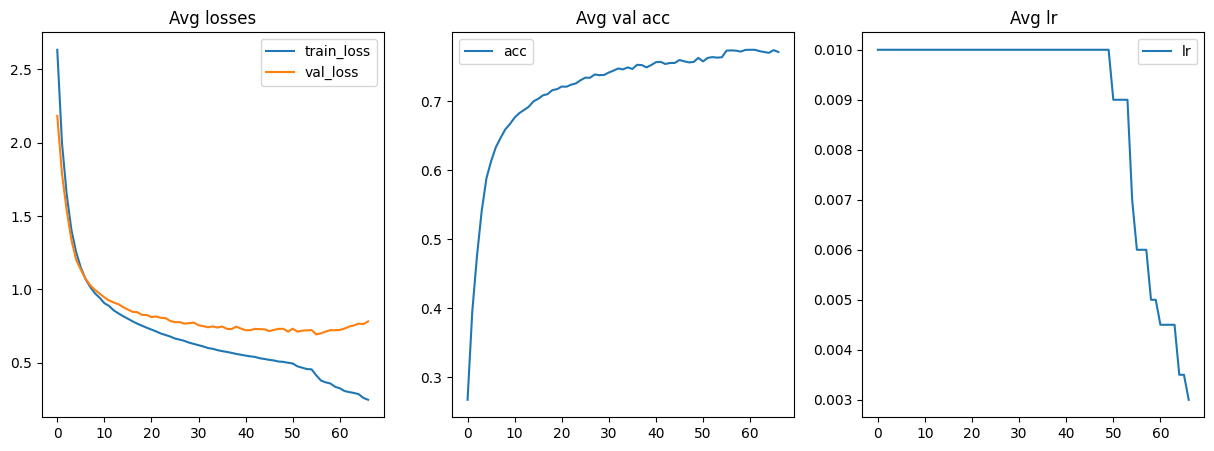

In [10]:
## LSTM

%autoreload

n_folds = 5
epochs = 100
lr = 0.01
            
LSTM_params = {
    "input_size":len(x_cols) if not embeddings else len(x_cols)-3 + 3*8,
    "hidden_size":128,
    "num_layers":2,
    "bidirectional":True,
    "dropout":0,
}

MLP_params = {
    "in_features":LSTM_params["hidden_size"],
    "n_layers":2, # max 3
    "out_features":24,
}

cross_validator = CV_pytorch(cv=n_folds, epochs=epochs, verbose=True)
model = cross_validator(LSTM_params, MLP_params, full_dataset, lr=lr, rnn_type="lstm", embeddings=embeddings, only_one=False)
cross_validator.plot_history()

In [12]:
cross_validator.histories

[   epoch train_loss  val_loss       acc      lr
 0      1   2.669171  2.201544  0.260533    0.01
 1      2   2.035541  1.816971  0.389858    0.01
 2      3   1.663271   1.56216  0.465053    0.01
 3      4   1.441927  1.397312  0.519043    0.01
 4      5   1.291285  1.230888  0.578439    0.01
 5      6   1.165037  1.147022  0.609619    0.01
 6      7   1.074432  1.076122  0.630929    0.01
 7      8   1.009772  1.032195  0.649205    0.01
 8      9   0.970005  1.009158  0.656703    0.01
 9     10   0.936379  0.953746  0.675119    0.01
 10    11   0.898361  0.944241  0.675398    0.01
 11    12   0.883502  0.907965  0.686314    0.01
 12    13    0.84948  0.912351  0.689488    0.01
 13    14   0.827542  0.897835  0.694754    0.01
 14    15   0.807269   0.89214   0.69308    0.01
 15    16     0.7907  0.865828  0.702009    0.01
 16    17   0.772879  0.862558   0.70302    0.01
 17    18   0.756661  0.870658  0.699149    0.01
 18    19   0.753473  0.818047  0.719971    0.01
 19    20   0.733187

In [11]:
# Save model

today = datetime.today().strftime('%Y-%m-%d %H:%M:%S')

best_model = model
EPOCH = epochs
PATH_MODEL = f"checkpoints/{today}_best_{EPOCH}.pt"
LOSS = cross_validator.best_val_losses[np.argmax(cross_validator.best_val_losses)]
PARAMS = LSTM_params
HISTORY = cross_validator.histories
torch.save({
            'epoch': EPOCH,
            'model_state_dict': best_model.state_dict(),
            'loss': LOSS,
            'PARAMS': PARAMS,
            'HISTORY':HISTORY
            }, PATH_MODEL)

print("Best model saved!")

Best model saved!


In [17]:
# Submission

device = get_device()
print(f"Using {device}.")

PATH_MODEL = "/home/hugocth/repos/kaggle/CFM_HFT/checkpoints/2024-02-02 03:48:38_best_100.pt"

test_data = raw_test_data.copy()

MLP_params = {
    "in_features":LSTM_params["hidden_size"],
    "n_layers":2, # max 3
    "out_features":24,
}


trained_model = torch.load(PATH_MODEL)
model = biLSTMClassifier(trained_model["PARAMS"], MLP_params, embeddings)
model.load_state_dict(trained_model["model_state_dict"])
model.to(device)
print(model)
print(f"Val loss of this model: {trained_model['loss']}")

today = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
PATH_SUB = f"submissions/{today}-biLSTM_2-layers_{trained_model['epoch']}.csv"

def make_submission(x_test, model, path, batch_size=512):
    print(f"Making submission {PATH_SUB}...")
    x_test = replace_abnormal(x_test)
    x_test, x_cols = add_features(x_test, embeddings=embeddings)
    test_dataloader = DataLoader(TestDataset(x_test, x_cols), batch_size=batch_size, shuffle=False, drop_last=False)
    preds = []
    for batch, X in enumerate(tqdm(test_dataloader, desc="Predicting")):
        preds += list(predict(X, model).astype(int))
    sub_df = pd.DataFrame(preds, columns=["eqt_code_cat"])
    sub_df.index.names = ["obs_id"]
    sub_df.to_csv(path)
    print("Submission done!")

make_submission(test_data, model, PATH_SUB)

Using cuda:0.
biLSTMClassifier(
  (norm): LayerNorm((100, 35), eps=1e-05, elementwise_affine=True)
  (LSTM): LSTM(35, 128, num_layers=2, bidirectional=True)
  (MLP): Sequential(
    (dense_1): Linear(in_features=512, out_features=256, bias=True)
    (act_1): SELU()
    (dense_2): Linear(in_features=256, out_features=24, bias=True)
  )
  (embed_venue): Embedding(6, 8)
  (embed_action): Embedding(3, 8)
  (embed_trade): Embedding(2, 8)
)
Val loss of this model: 0.705037806715284
Making submission submissions/2024-02-03 14:49:29-biLSTM_2-layers_100.csv...
Replaced 10 abnormal observations.
Feature engineering completed: 14 features.


Predicting: 100%|██████████| 160/160 [00:02<00:00, 55.01it/s]


Submission done!
